In [57]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [58]:
clim = pd.read_csv('Climate_twitter.csv')
bt = pd.read_csv('twitter_sentiment_data.csv')
json = pd.read_json('train.jsonl', lines=True)

In [59]:
# adding label based on polarity score
conditions = [
    (clim['polarity'] < 0),
    (clim['polarity'] > 0),
    (clim['polarity'] == 0)]

values = [0,1, 'neutral']

clim['label'] = np.select(conditions, values)

clim.head()

,id,date,retweets,source,author,likes,text,twitter_name,location,verified,followers,friends,polarity,subjectivity,label
0,2184934963,2020-12-22 23:22:20,71,Twitter Web App,GO GREEN,91,The death of summer Arctic ice our Earth coole...,ECOWARRIORSS,NaN,False,23415,20439,-0.054365,0.426984,0
1,508658626,2020-12-10 14:30:00,14,Twitter for Advertisers,Elsevier Energy,98,Elsevier and the EditorsinChief are pleased to...,ElsevierEnergy,"Oxford, England",False,6615,508,0.387500,0.633333,1
2,2607105006,2020-12-22 21:28:52,0,Twitter Web App,Arwyn Thomas,1,From better climate change education to improv...,siwarr5,Carmarthen,False,22,133,0.261905,0.345238,1
3,19609660,2020-12-22 21:24:10,0,Twitter Web App,"Tom Gillispie, EDITOR/WRITER",0,climate change Links to FIXING CLIMATE CHANGE ...,EDITORatWORK,"Rural Hall, North Carolina, USA",False,4191,3708,0.000000,0.000000,neutral
4,19609660,2020-12-21 22:52:09,1,Twitter Web App,"Tom Gillispie, EDITOR/WRITER",1,climate change The 11TH HOUR FOR THE EARTH cli...,EDITORatWORK,"Rural Hall, North Carolina, USA",False,4191,3708,0.000000,0.000000,neutral


In [60]:
# dropping neutral entries
clim = clim.drop(clim[clim['label'] == 'neutral'].index)

In [61]:
# dropping all columns except text and label
clim = clim.drop(columns = ['id','date','source','author','twitter_name','location','verified','retweets','likes','followers','friends','polarity','subjectivity'])

In [62]:
clim.info()
clim['text'] = clim['text'].astype('string')
clim['label'] = clim['label'].astype('int64')
clim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    270 non-null    object
 1   label   270 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    270 non-null    string
 1   label   270 non-null    int64 
dtypes: int64(1), string(1)
memory usage: 6.3 KB


In [63]:
bt.head()
bt = bt.drop(columns=['tweetid'])

In [64]:
bt.rename(columns={'sentiment': "label", 'message':'text'}, inplace=True)

In [65]:
bt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   43943 non-null  int64 
 1   text    43943 non-null  object
dtypes: int64(1), object(1)
memory usage: 686.7+ KB


In [66]:
bt['label'].value_counts() # imbalance

label
 1    22962
 2     9276
 0     7715
-1     3990
Name: count, dtype: int64

In [67]:
bt = bt.drop(bt[bt['label'] ==  2].index)

In [68]:
bt = bt.drop(bt[bt['label'] == 0].index)

In [69]:
bt.dropna(subset=['label'], inplace=True)

In [70]:
conditions = [
    (bt['label'] == -1),
    (bt['label'] == 1)]

values = [0,1]

bt['sent'] = np.select(conditions, values)

In [71]:
bt['label'] = bt['sent']
bt=bt.drop(columns=['sent'])

In [72]:
bt['text'] = bt['text'].astype("string")
bt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26952 entries, 0 to 43942
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   26952 non-null  int64 
 1   text    26952 non-null  string
dtypes: int64(1), string(1)
memory usage: 631.7 KB


In [73]:
bt['label'].value_counts()

label
1    22962
0     3990
Name: count, dtype: int64

In [74]:
json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2117 non-null   object
 1   label   2117 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.2+ KB


In [75]:
json['label'].value_counts()

label
0    1585
1     532
Name: count, dtype: int64

In [76]:
df_list = [clim, bt, json]
df = pd.concat(df_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29339 entries, 0 to 2116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29339 non-null  object
 1   label   29339 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 687.6+ KB


In [77]:
df['text'] = df['text'].astype('string')

In [78]:
df['label'].value_counts()

label
1    23684
0     5655
Name: count, dtype: int64

#### Dataset Preprocessing: Filteration

In [79]:
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tessanderson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [80]:
nltk.download('punkt')  # Download the punkt tokenizer if not already downloaded

df['tokens'] = df['text'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tessanderson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
keywords = ["sustainability", "environmental", "conservation", "recycling", "sustainable",
                         "responsibility", "green", "eco-friendly", "renewable", "carbon", "climate", "ecosystem",
                         "planet", "biodiversity", "energy", "water", "pollution", "reduction", "renewability",
                         "ecological", "renewable", "greenhouse", "clean", "solar", "wind", "earth", "sustainable",
                         "planet", "ecology", "ocean", "forest", "organic", "earth-friendly", "bio", "ethics",
                         "conservationist", "sustain", "renew", "ethical", "greenery", "saver", "sustainable",
                         "conservator", "recycler", "biodegradable", "natural", "greenery", "environment",
                         "saver", "earth-saving", "sustainability", "green-living", "clean", "responsible",
                         "preservation", "regeneration", "ecosystem", "safeguarding"]
filtered_df = df[df['tokens'].apply(lambda tokens: any(keyword in tokens for keyword in keywords))]

In [82]:
filtered_df['label'].value_counts()

label
1    19287
0     2412
Name: count, dtype: int64

#### When we are using an imbalanced dataset, we can oversample the minority class using replacement. Thsi tehnique is called oversampling.

In [83]:
from sklearn.utils import resample
df1 = filtered_df.loc[filtered_df['label'] == 0]
df2 = filtered_df.loc[filtered_df['label'] == 1]
df1_sampled=resample(df1, replace=True,
                     n_samples= 19287,
                     random_state=42)
# reproducible results
filtered_df= pd.concat([df1_sampled, df2])
filtered_df.info()
filtered_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 38574 entries, 20004 to 2115
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38574 non-null  string
 1   label   38574 non-null  int64 
 2   tokens  38574 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 1.2+ MB


label
0    19287
1    19287
Name: count, dtype: int64

#### Splitting the data: train, test, and validation

In [84]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

train_df, test_df = train_test_split(filtered_df, test_size = .2, random_state=42)

#### Preprocessing

In [85]:
sentiment_counts = train_df['label'].value_counts()
 
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')
 
fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')
 
# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [86]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [87]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['text'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['text'].apply(text_cleaning)

/var/folders/bn/mdffb48j50d5vh0gf4cs_6v00000gn/T/ipykernel_5624/3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/bn/mdffb48j50d5vh0gf4cs_6v00000gn/T/ipykernel_5624/3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [88]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800, 
						height=400,
						stopwords=set(STOPWORDS), 
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()

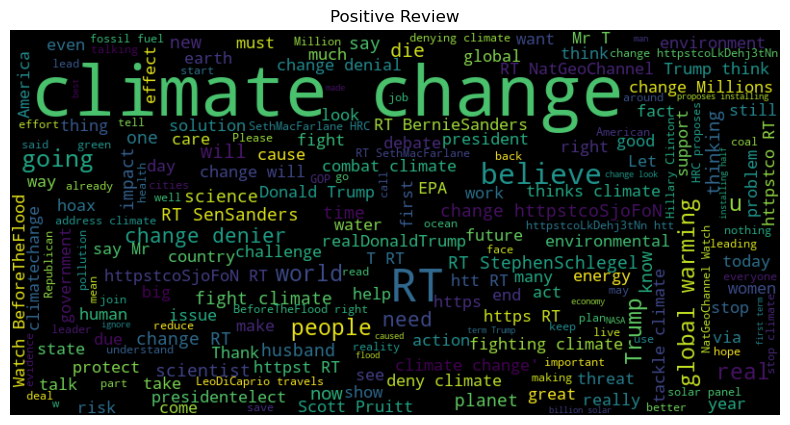

In [89]:
positive = train_df[train_df['label']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

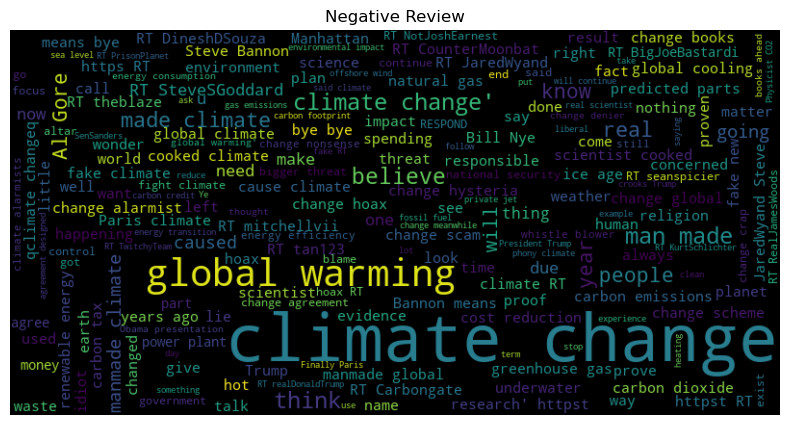

In [90]:
negative = train_df[train_df['label']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [91]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Text = train_df['Cleaned_sentence']
Label = train_df['label']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_text = test_df['Cleaned_sentence']
test_label = test_df['label']

In [92]:
x_val, x_test, y_val, y_test = train_test_split(test_text,
													test_label,
													test_size=0.5, 
													stratify = test_label)


In [93]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Text.tolist(),
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [94]:
k = 0
print('Training Comments -->>',Text[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Label[k])

Training Comments -->> 0    tiniebeany climate change is an interesting hu...
0    tiniebeany climate change is an interesting hu...
0    The death of summer Arctic ice our Earth coole...
0    The death of summer Arctic ice our Earth coole...
0    The death of summer Arctic ice our Earth coole...
0    tiniebeany climate change is an interesting hu...
0    tiniebeany climate change is an interesting hu...
0    tiniebeany climate change is an interesting hu...
0    The death of summer Arctic ice our Earth coole...
Name: Cleaned_sentence, dtype: object

Input Ids -->>
 tf.Tensor(
[  101 19387  4074 13699  8602  5989  1997  6529  2079  2025  5993  2008
  4785  2689  2097  2022 23546  2030  2007  3021 23168  2015  3343  7300
 16770  2102   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [95]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [97]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Label,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)

Epoch 1/3
965/965 [==============================] - 6502s 7s/step - loss: 0.2676 - accuracy: 0.8856 - val_loss: 0.0789 - val_accuracy: 0.9754
Epoch 2/3
965/965 [==============================] - 6067s 6s/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 0.0594 - val_accuracy: 0.9816
Epoch 3/3
965/965 [==============================] - 4625s 5s/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.0502 - val_accuracy: 0.9844


In [98]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


121/121 [==============================] - 145s 1s/step - loss: 0.0481 - accuracy: 0.9883
Test loss: 0.04814286157488823, Test accuracy: 0.988335907459259


In [99]:
path = 'path-to-save'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [100]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassificati

In [101]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])

121/121 [==============================] - 149s 1s/step
Predicted Label : ['positive', 'Negative', 'Negative', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative']
Actual Label : ['positive', 'Negative', 'Negative', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative']


In [102]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99      1911
    positive       1.00      0.98      0.99      1947

    accuracy                           0.99      3858
   macro avg       0.99      0.99      0.99      3858
weighted avg       0.99      0.99      0.99      3858

